In [1]:
import numpy as np              # Массивы (матрицы, векторы, линейная алгебра)
import matplotlib.pyplot as plt # Научная графика
%matplotlib inline 
  
import pandas as pd             # Таблицы и временные ряды (dataframe, series)
import seaborn as sns           # Еще больше красивой графики для визуализации данных
import sklearn                  # Алгоритмы машинного обучения

In [2]:
from google.colab import files
uploaded = files.upload()

Saving airline_passenger_satisfaction.csv to airline_passenger_satisfaction (3).csv


In [3]:
import io
data_r = pd.read_csv(io.BytesIO(uploaded['airline_passenger_satisfaction.csv']))

In [4]:
data_r.columns

Index(['Unnamed: 0', 'Gender', 'customer_type', 'age', 'type_of_travel',
       'customer_class', 'flight_distance', 'inflight_wifi_service',
       'departure_arrival_time_convenient', 'ease_of_online_booking',
       'gate_location', 'food_and_drink', 'online_boarding', 'seat_comfort',
       'inflight_entertainment', 'onboard_service', 'leg_room_service',
       'baggage_handling', 'checkin_service', 'inflight_service',
       'cleanliness', 'departure_delay_in_minutes', 'arrival_delay_in_minutes',
       'satisfaction'],
      dtype='object')

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer

In [5]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from collections import Counter
from sklearn.metrics import euclidean_distances

In [6]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error

In [7]:
from sklearn.model_selection import GridSearchCV

In [8]:
from sklearn.metrics import accuracy_score

In [9]:
import joblib

In [10]:
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, roc_curve, classification_report, ConfusionMatrixDisplay

# Использование pipeline для предобработки

Напишем свою функцию для заполнения пропущенных значений для arrival_delay_in_minutes, далее трансформеры и объединяем их в общий pipeline. В итоге мы реализовали все пункты сделанные в 0ой работе (кроме визуализации). StandardScaler() - масштабировал (нормализовал данные), SpInpTransformer - заполнил пропущенные значения для arrival_delay_in_minutes, OneHotEncoder - перевел категориальные признаки. ColumnTransformer позволил дополнить необходимые преобразования - удалить не сильно влияющие на уровень удовлетворенности столбцы, выполнить описанные выше преобразования.

In [11]:
def ffill(data_r):
  if 'arrival_delay_in_minutes' in data_r:
    data_r['arrival_delay_in_minutes'].fillna(data_r['departure_delay_in_minutes'], inplace = True)
  return data_r
  
class SpInpTransformer():
  def __init__(self,f):
    self.func = f

  def transform(self, input_df, **transform_params):
    return self.func(input_df)
  
  def fit(self, X, y = None, **fit_params):
    return self

drop_feat = ['Gender', 'customer_type', 'age',
       'departure_arrival_time_convenient', 'customer_class',
       'gate_location', 'food_and_drink', 'onboard_service', 'leg_room_service',
       'baggage_handling', 'checkin_service', 'inflight_service',
       'cleanliness', 'departure_delay_in_minutes','flight_distance','departure_delay_in_minutes']

numeric_features = ['inflight_wifi_service', 'ease_of_online_booking',
                    'online_boarding', 'seat_comfort', 'inflight_entertainment', 
                    'arrival_delay_in_minutes']

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),("scaler", StandardScaler())]
    )

categorical_features = ['type_of_travel']

categorical_transformer = Pipeline(
    steps=[('onehotenc', OneHotEncoder(handle_unknown="ignore"))]
    )

col_transformer = ColumnTransformer(transformers = 
                                     [('drop_columns', 'drop', drop_feat),
                                      ('num_processing',numeric_transformer, numeric_features),
                                      ('cat_processing', categorical_transformer, categorical_features)
                                      ], remainder = 'drop')

In [12]:
X = data_r.drop(['satisfaction','Unnamed: 0'], axis=1)
data_r['satisfaction'] = pd.factorize(data_r['satisfaction'])[0]
y = data_r['satisfaction']

X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2, random_state=124)

# Логистическая регрессия

In [14]:
from sklearn.linear_model import LogisticRegression

Моя реализация:
выполнено наследование от BaseEstimator, ClassifierMixin, реализованы fit и predict в соответствии со стандартами scikit-learn.

In [15]:
class Classifier_log_regression(BaseEstimator, ClassifierMixin):

    def __init__(self, lr = 0.0001, n = 100):
        self.lr = lr
        self.n = n
        self.w = None
        self.b = None
    
    def fit(self, X, y):

        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        
        self.w = np.zeros(X.shape[1])
        self.b = 0
        
        for _ in range(self.n):
            l_m = np.dot(X, self.w)+ self.b
            pred_labels = self._sigmoid(l_m)

            dw = (1/self.n)*np.dot(X.T, pred_labels - y)
            db = (1/self.n)*np.sum(pred_labels - y)
            
            self.w -= self.lr * dw
            self.b -= self.lr * db
        # Return the classifier
        return self

    def predict(self, X):

        # Check is fit had been called
        check_is_fitted(self, ['w', 'b'])

        # Input validation
        X = check_array(X)
        
        l_m =np.dot(X, self.w)+self.b
        pred_labels = self._sigmoid(l_m)
        pred_labels_cls = [1 if i > 0.5 else 0 for i in pred_labels]
        return np.array(pred_labels_cls)

    def _sigmoid(self, x): 
        return 1/(1+np.exp(-x))

pipeline для последубщего обучения и тестирования

In [16]:
my_clf = Pipeline(
    [
        ("fill_spaces", SpInpTransformer(ffill)),
        ("transform_column", col_transformer),
        ("model", Classifier_log_regression())
    ])
clf = Pipeline(
    [
        ("fill_spaces", SpInpTransformer(ffill)),
        ("transform_column", col_transformer),
        ("model", LogisticRegression())
    ])

Обучение и тестирование для моей модели:

In [17]:
print('for my model:')
my_clf.fit(X_train, y_train)
y_pred_test = my_clf.predict(X_test)
y_pred_train = my_clf.predict(X_train)
print('confusion_matrix for test \n', confusion_matrix(y_test, y_pred_test))
print('confusion_matrix for train \n', confusion_matrix(y_train, y_pred_train))
MSE_train = mean_squared_error(y_train, y_pred_train)
MSE_test  = mean_squared_error(y_test,  y_pred_test)
print('MSE train = ', MSE_train, 'MSE test = ', MSE_test)
acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test,  y_pred_test)
print('acc train = ', acc_train, 'acc test = ', acc_test)

for my model:
confusion_matrix for test 
 [[12359  2251]
 [ 2300  9066]]
confusion_matrix for train 
 [[49779  9063]
 [ 8767 36295]]
MSE train =  0.1716007083461657 MSE test =  0.17520018478595628
acc train =  0.8283992916538343 acc test =  0.8247998152140438


Обучение и тестирование для sklearn модели:

In [18]:
print('for sklern model:')
clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))
y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train)
print('confusion_matrix for test \n', confusion_matrix(y_test, y_pred_test))
print('confusion_matrix for train \n', confusion_matrix(y_train, y_pred_train))
MSE_train = mean_squared_error(y_train, y_pred_train)
MSE_test  = mean_squared_error(y_test,  y_pred_test)
print('MSE train = ', MSE_train, 'MSE test = ', MSE_test)
acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test,  y_pred_test)
print('acc train = ', acc_train, 'acc test = ', acc_test)

for sklern model:
model score: 0.831
confusion_matrix for test 
 [[12444  2166]
 [ 2222  9144]]
confusion_matrix for train 
 [[50112  8730]
 [ 8437 36625]]
MSE train =  0.16521981829380966 MSE test =  0.16892516168771174
acc train =  0.8347801817061903 acc test =  0.8310748383122882


Результат встроенной модели оказался лучше примерно на 1 процент, я думаю это связано с большим количеством варьируемых параметров в sklearn.

Реализуем поиск по сетке с кросс-валидацией

In [19]:
parameters = {'model__C': np.logspace(-10, 10, 20), 'model__penalty':['l1', 'l2'], 'model__solver':['liblinear']}

grid_search = GridSearchCV(clf,  
                           param_grid = parameters,
                           cv = 5)

grid_search.fit(X_train, y_train)   

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('fill_spaces',
                                        <__main__.SpInpTransformer object at 0x7efc90ab0d10>),
                                       ('transform_column',
                                        ColumnTransformer(transformers=[('drop_columns',
                                                                         'drop',
                                                                         ['Gender',
                                                                          'customer_type',
                                                                          'age',
                                                                          'departure_arrival_time_convenient',
                                                                          'customer_class',
                                                                          'gate_location',
                                                   

In [20]:
print('Best Params:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)
print(grid_search.best_estimator_.get_params()['model'])

Best Params: {'model__C': 0.002335721469090121, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
Best score: 0.8414690521840141
LogisticRegression(C=0.002335721469090121, penalty='l1', solver='liblinear')


В результате лучшими параметрами оказались 'model__C': 0.002335721469090121, 'model__penalty': 'l1'

In [21]:
y_pred_test = grid_search.predict(X_test)
acc_test = accuracy_score(y_test,  y_pred_test)
acc_test

0.8348860486603018

Но точность на тестовой выборке практически не изменилась.

Получим еще оценки:

In [22]:
recall_score(y_test, y_pred_test)

0.8005454865388

In [23]:
precision_score(y_test, y_pred_test)

0.8181818181818182

fpr: [0.         0.13839836 1.        ]
tpr: [0.         0.80054549 1.        ]
thresholds: [2 1 0]
AUC: 0.8310735646246361





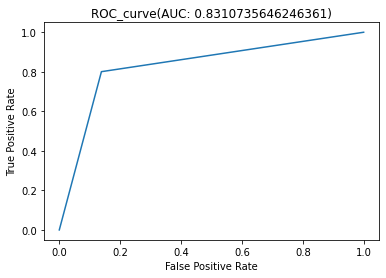

In [24]:
from sklearn.metrics import auc 
  
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test, pos_label=1) 
print('fpr: ' + str(fpr))
print('tpr: ' + str(tpr))
print('thresholds: ' + str(thresholds))
 
  
AUC = auc(fpr, tpr) 
print('AUC: ' + str(AUC))
 
print('\n\n')
plt.plot(fpr, tpr)  
plt.title('ROC_curve' + '(AUC: ' + str(AUC) + ')' )  
plt.ylabel('True Positive Rate')  
plt.xlabel('False Positive Rate')  
plt.show()

Сохраним эти гиперпараметры в файл, вместе с обученной моделью

In [25]:
joblib.dump(clf, "log_reg_model.pkl")

['log_reg_model.pkl']

проверим

In [26]:
clf_log_reg = joblib.load("log_reg_model.pkl")
y_pred = clf_log_reg.predict(X_test)

In [27]:
accuracy_score(y_test, y_pred)

0.8310748383122882

# KNN

In [28]:
from sklearn.neighbors import KNeighborsRegressor

In [29]:
from sklearn.decomposition import PCA

Моя реализация: выполнено наследование от BaseEstimator, ClassifierMixin, реализованы fit и predict в соответствии со стандартами scikit-learn.

In [30]:
def eucl_dist(x1, x2):
      return np.sqrt(np.sum(x1-x2)**2)

class Classifier_knn(BaseEstimator, ClassifierMixin):

    def __init__(self, k = 20):
        self.k = k
    
    def fit(self, X, y):

        # Check that X and y have correct shape
        X, y = check_X_y(X, y)

        self.X = X
        self.y = y
        # Return the classifier
        return self

    def predict(self, X):

        # Check is fit had been called
        check_is_fitted(self, ['X', 'y'])

        # Input validation
        X = check_array(X)
        
        pred_labels = [self.pred_for_each(x) for x in X]
        return np.array(pred_labels)
  
    def pred_for_each(self, x):
        dist = [eucl_dist(x, xx) for xx in self.X]
        idx = np.argsort(dist)[:self.k]
        labels = [self.y[i] for i in idx]
        most_common = Counter(labels).most_common(1)
        return most_common[0][0]


pipeline для последубщего обучения и тестирования

In [31]:
my_clf = Pipeline(
    [
        ("fill_spaces", SpInpTransformer(ffill)),
        ("transform_column", col_transformer),
        ("model", Classifier_knn())
    ])
clf = Pipeline(
    [
        ("fill_spaces", SpInpTransformer(ffill)),
        ("transform_column", col_transformer),
        ('pca', PCA()),
        ("model", KNeighborsRegressor())
    ])

Обучение и тестирование для моей модели:

In [13]:
data_r = data_r.sample(n=10000, replace=False, axis=0) 
X1 = data_r.drop(['satisfaction','Unnamed: 0'], axis=1)
data_r['satisfaction'] = pd.factorize(data_r['satisfaction'])[0]
y1 = data_r['satisfaction']

In [14]:
X_train1, X_test1, y_train1, y_test1  = train_test_split(X1, y1, test_size=0.2, random_state=124)

In [34]:
X_test1.shape

(2000, 22)

In [35]:
print('for my model:')
my_clf.fit(X_train1, y_train1)
y_pred_test = my_clf.predict(X_test1)
y_pred_train = my_clf.predict(X_train1)
print('confusion_matrix for test \n', confusion_matrix(y_test1, y_pred_test))
print('confusion_matrix for train \n', confusion_matrix(y_train1, y_pred_train))
MSE_train = mean_squared_error(y_train1, y_pred_train)
MSE_test  = mean_squared_error(y_test1,  y_pred_test)
print('MSE train = ', MSE_train, 'MSE test = ', MSE_test)
acc_train = accuracy_score(y_train1, y_pred_train)
acc_test = accuracy_score(y_test1,  y_pred_test)
print('acc train = ', acc_train, 'acc test = ', acc_test)

for my model:
confusion_matrix for test 
 [[903 231]
 [259 607]]
confusion_matrix for train 
 [[3789  709]
 [ 890 2612]]
MSE train =  0.199875 MSE test =  0.245
acc train =  0.800125 acc test =  0.755


Обучение и тестирование для sklearn модели:

In [36]:
grid_searcher = GridSearchCV(
    clf,
    param_grid={
        'pca__n_components': [2, 3, 4, 5, 6, 7],
        'model__n_neighbors': range(5, 30, 5),
        'model__weights': ['distance'],
        'model__p': [2]
    },
    cv=3
)

In [37]:
%%time

grid_searcher.fit(X_train, y_train)

CPU times: user 1min 25s, sys: 26.9 s, total: 1min 52s
Wall time: 1min 23s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('fill_spaces',
                                        <__main__.SpInpTransformer object at 0x7efc8e1638d0>),
                                       ('transform_column',
                                        ColumnTransformer(transformers=[('drop_columns',
                                                                         'drop',
                                                                         ['Gender',
                                                                          'customer_type',
                                                                          'age',
                                                                          'departure_arrival_time_convenient',
                                                                          'customer_class',
                                                                          'gate_location',
                                                   

Рассмотрим предсказание лучшей модели

In [38]:
y_pred_test = grid_searcher.predict(X_test).astype(int)
y_pred_train = grid_searcher.predict(X_train).astype(int)
print('confusion_matrix for test \n', confusion_matrix(y_test, y_pred_test))
print('confusion_matrix for train \n', confusion_matrix(y_train, y_pred_train))
MSE_train = mean_squared_error(y_train, y_pred_train)
MSE_test  = mean_squared_error(y_test,  y_pred_test)
print('MSE train = ', MSE_train, 'MSE test = ', MSE_test)
acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test,  y_pred_test)
print('acc train = ', acc_train, 'acc test = ', acc_test)

confusion_matrix for test 
 [[14578    32]
 [ 4321  7045]]
confusion_matrix for train 
 [[58818    24]
 [16579 28483]]
MSE train =  0.15979173082845705 MSE test =  0.16757776408992917
acc train =  0.840208269171543 acc test =  0.8324222359100708


Точность предсказания на тестовой выборке гораздо лучше чем у моей модели. Думаю, это связано с тем что при применении классического алгоритмя всего объема данных было слишком много, поэтому при обучении на части данных предсказание оказалось хуже.

In [39]:
grid_searcher.best_params_

{'model__n_neighbors': 25,
 'model__p': 2,
 'model__weights': 'distance',
 'pca__n_components': 7}

Получим еще оценки:

In [40]:
recall_score(y_test, y_pred_test)

0.6198310751363716

In [41]:
precision_score(y_test, y_pred_test)

0.9954783100183694

fpr: [0.         0.00219028 1.        ]
tpr: [0.         0.61983108 1.        ]
thresholds: [2 1 0]
AUC: 0.808820397253333





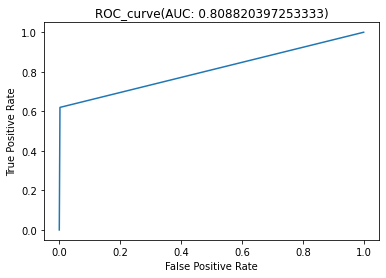

In [42]:
from sklearn.metrics import auc 
  
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test, pos_label=1) 
print('fpr: ' + str(fpr))
print('tpr: ' + str(tpr))
print('thresholds: ' + str(thresholds))
 
  
AUC = auc(fpr, tpr) 
print('AUC: ' + str(AUC))
 
print('\n\n')
plt.plot(fpr, tpr)  
plt.title('ROC_curve' + '(AUC: ' + str(AUC) + ')' )  
plt.ylabel('True Positive Rate')  
plt.xlabel('False Positive Rate')  
plt.show()

Сохраним эти гиперпараметры в файл, вместе с обученной моделью

In [43]:
joblib.dump(grid_searcher, "knn_model.pkl")

['knn_model.pkl']

проверим

In [44]:
clf_knn = joblib.load("knn_model.pkl")
y_pred = clf_knn.predict(X_test)

In [45]:
accuracy_score(y_test, y_pred.astype(int))

0.8324222359100708

# SVM

In [15]:
from sklearn.svm import SVC

Моя реализация: выполнено наследование от BaseEstimator, ClassifierMixin, реализованы fit и predict в соответствии со стандартами scikit-learn.

In [16]:
class SVM_classifier(BaseEstimator, ClassifierMixin):

    def __init__(self, lr = 0.001, lambd = 0.01, n = 1000):
        self.lr = lr
        self.lambd = lambd
        self.n = n
        self.w = None
        self.b = None
    
    def fit(self, X, y):

        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        
        y_ = np.where(y <= 0, -1, 1)
        n_samp, n_ft = X.shape

        self.w = np.zeros(n_ft)
        self.b = 0

        for _ in range(self.n):
          for idx, x_i in enumerate(X):
            cond = y_[idx] * (np.dot(x_i, self.w)-self.b) >= 1
            if cond:
              self.w -= self.lr * (2*self.lambd*self.w)
            else:
              self.w -= self.lr * (2*self.lambd*self.w - np.dot(x_i, y_[idx]))
              self.b -= self.lr * y_[idx]
        # Return the classifier
        return self

    def predict(self, X):

        # Check is fit had been called
        check_is_fitted(self, ['w', 'b'])

        # Input validation
        X = check_array(X)
        
        l_o =np.dot(X, self.w) - self.b
        return np.sign(l_o)

pipeline для последубщего обучения и тестирования

In [17]:
my_clf = Pipeline(
    [
        ("fill_spaces", SpInpTransformer(ffill)),
        ("transform_column", col_transformer),
        ("method", SVM_classifier())
    ])
clf = Pipeline(
    [
        ("fill_spaces", SpInpTransformer(ffill)),
        ("transform_column", col_transformer),
        ("model", SVC())
    ])

Обучение и тестирование для моей модели:

In [19]:
y_train1 = np.where(y_train1==0, -1,1)
y_test1 = np.where(y_test1==0, -1,1)

In [20]:
print('for my model:')
my_clf.fit(X_train1, y_train1)
y_pred_test = my_clf.predict(X_test1)
y_pred_train = my_clf.predict(X_train1)
print('confusion_matrix for test \n', confusion_matrix(y_test1, y_pred_test))
print('confusion_matrix for train \n', confusion_matrix(y_train1, y_pred_train))
MSE_train = mean_squared_error(y_train1, y_pred_train)
MSE_test  = mean_squared_error(y_test1,  y_pred_test)
print('MSE train = ', MSE_train, 'MSE test = ', MSE_test)
acc_train = accuracy_score(y_train1, y_pred_train)
acc_test = accuracy_score(y_test1,  y_pred_test)
print('acc train = ', acc_train, 'acc test = ', acc_test)

for my model:
confusion_matrix for test 
 [[1000  131]
 [ 191  678]]
confusion_matrix for train 
 [[4107  514]
 [ 684 2695]]
MSE train =  0.599 MSE test =  0.644
acc train =  0.85025 acc test =  0.839


Даже лишь на двух тысячах данных отличная точность на тестовой выборке - 84%.

Обучение и тестирование для sklearn модели:

In [29]:
print('for sklern model:')
clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))
y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train)
print('confusion_matrix for test \n', confusion_matrix(y_test, y_pred_test))
print('confusion_matrix for train \n', confusion_matrix(y_train, y_pred_train))
MSE_train = mean_squared_error(y_train, y_pred_train)
MSE_test  = mean_squared_error(y_test,  y_pred_test)
print('MSE train = ', MSE_train, 'MSE test = ', MSE_test)
acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test,  y_pred_test)
print('acc train = ', acc_train, 'acc test = ', acc_test)

for sklern model:
model score: 0.921
confusion_matrix for test 
 [[13580  1030]
 [ 1025 10341]]
confusion_matrix for train 
 [[54730  4112]
 [ 4199 40863]]
MSE train =  0.07998729596550662 MSE test =  0.07911148752694795
acc train =  0.9200127040344934 acc test =  0.920888512473052


Отличная точность предсказаний, пока эта модель лучше всего подходит для данного датасета.

Реализуем поиск по сетке с кросс-валидацией

Пришлось обучать лишь на части всего объема данных, так как при использовании всего датасета не хватило и двух часов , чтобы реализовать поиск по сетке с кросс валидацией

In [19]:
param_grid = {'model__C':[1,10,100],'model__gamma':[1,0.1,0.001], 'model__kernel':['linear','rbf']}
grid = GridSearchCV(clf,  
                    param_grid,
                    refit = True, 
                    verbose=2,
                    cv = 5)

grid.fit(X_train1, y_train1)   

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ...model__C=1, model__gamma=1, model__kernel=linear; total time=   2.0s
[CV] END ...model__C=1, model__gamma=1, model__kernel=linear; total time=   1.5s
[CV] END ...model__C=1, model__gamma=1, model__kernel=linear; total time=   1.5s
[CV] END ...model__C=1, model__gamma=1, model__kernel=linear; total time=   1.5s
[CV] END ...model__C=1, model__gamma=1, model__kernel=linear; total time=   1.4s
[CV] END ......model__C=1, model__gamma=1, model__kernel=rbf; total time=   1.4s
[CV] END ......model__C=1, model__gamma=1, model__kernel=rbf; total time=   1.4s
[CV] END ......model__C=1, model__gamma=1, model__kernel=rbf; total time=   1.3s
[CV] END ......model__C=1, model__gamma=1, model__kernel=rbf; total time=   1.4s
[CV] END ......model__C=1, model__gamma=1, model__kernel=rbf; total time=   1.4s
[CV] END .model__C=1, model__gamma=0.1, model__kernel=linear; total time=   1.4s
[CV] END .model__C=1, model__gamma=0.1, model__k

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('fill_spaces',
                                        <__main__.SpInpTransformer object at 0x7fadba010750>),
                                       ('transform_column',
                                        ColumnTransformer(transformers=[('drop_columns',
                                                                         'drop',
                                                                         ['Gender',
                                                                          'customer_type',
                                                                          'age',
                                                                          'departure_arrival_time_convenient',
                                                                          'customer_class',
                                                                          'gate_location',
                                                   

Лучшие параметры:

In [20]:
print('Best Params:', grid.best_params_)
print('Best score:', grid.best_score_)
print(grid.best_estimator_.get_params()['model'])

Best Params: {'model__C': 1, 'model__gamma': 1, 'model__kernel': 'rbf'}
Best score: 0.9125
SVC(C=1, gamma=1)


для подвыборки:

In [26]:
y_pred_test = grid.predict(X_test1)
acc_test = accuracy_score(y_test1,  y_pred_test)
acc_test

0.9185

Для всего датасета:

In [27]:
y_pred_test = grid.predict(X_test)
acc_test = accuracy_score(y_test,  y_pred_test)
acc_test

0.08138281490606714

точность очень плохая, поэтому лучше оставить параметры по умолчанию, которые дали точность 92

Получим оценки для модели clf(которая дала точность 92):

In [30]:
recall_score(y_test, y_pred_test)

0.9098187576983987

In [31]:
precision_score(y_test, y_pred_test)

0.9094186966845484

fpr: [0.         0.07049966 1.        ]
tpr: [0.         0.90981876 1.        ]
thresholds: [2 1 0]
AUC: 0.9196595499648735





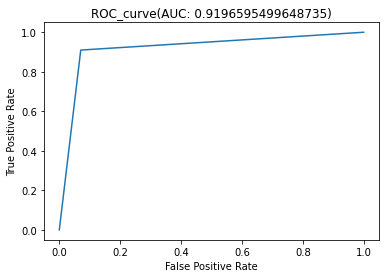

In [32]:
from sklearn.metrics import auc 
  
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test, pos_label=1) 
print('fpr: ' + str(fpr))
print('tpr: ' + str(tpr))
print('thresholds: ' + str(thresholds))
 
  
AUC = auc(fpr, tpr) 
print('AUC: ' + str(AUC))
 
print('\n\n')
plt.plot(fpr, tpr)  
plt.title('ROC_curve' + '(AUC: ' + str(AUC) + ')' )  
plt.ylabel('True Positive Rate')  
plt.xlabel('False Positive Rate')  
plt.show()

Сохранение в файл и проверка

In [33]:
joblib.dump(clf, "SVM_model.pkl")
clf_SVM = joblib.load("SVM_model.pkl")
y_pred = clf_SVM.predict(X_test)
accuracy_score(y_test, y_pred)

0.920888512473052

# Naive Bayes

In [34]:
from sklearn.naive_bayes import GaussianNB

Моя реализация: выполнено наследование от BaseEstimator, ClassifierMixin, реализованы fit и predict в соответствии со стандартами scikit-learn.

Гауссовский наивный байесовский алгоритм для классификации. Предполагается, что вероятность появления признаков гауссова

In [35]:
class Classifier_NB(BaseEstimator, ClassifierMixin):
    
    def fit(self, X, y):

        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        
        n_samp, n_ft = X.shape
        self._classes = np.unique(y)
        n_cl = len(self._classes)
        self._mean = np.zeros((n_cl, n_ft), dtype = np.float64)
        self._var = np.zeros((n_cl, n_ft), dtype = np.float64)
        self._priors = np.zeros(n_cl, dtype = np.float64)

        for classes in self._classes:
          X_c = X[classes == y]
          self._mean[classes,:] = X_c.mean(axis = 0)
          self._var[classes,:] = X_c.var(axis = 0)
          self._priors[classes] = X_c.shape[0] / float(n_samp)
        # Return the classifier
        return self

    def predict(self, X):

        # Check is fit had been called
        check_is_fitted(self, ['_mean', '_var', '_priors'])

        # Input validation
        X = check_array(X)
        
        pred_labels = [self.pred_for_each(x) for x in X]
        return np.array(pred_labels)

    def pred_for_each(self, x): 
        posts =[]

        for idx, c in enumerate(self._classes):
          prior = np.log(self._priors[idx])
          class_cond = np.sum(np.log(self._pdf(idx, x)))
          post = prior + class_cond
          posts.append(post)

        return self._classes[np.argmax(posts)]

    def _pdf(self, class_idx, x):
      mean = self._mean[class_idx] 
      var = self._var[class_idx] 
      return (np.exp(-(x-mean)**2/(2*var)))/(np.sqrt(2*np.pi*var))
      

pipeline для последубщего обучения и тестирования

In [36]:
my_clf = Pipeline(
    [
        ("fill_spaces", SpInpTransformer(ffill)),
        ("transform_column", col_transformer),
        ("model", Classifier_NB())
    ])
clf = Pipeline(
    [
        ("fill_spaces", SpInpTransformer(ffill)),
        ("transform_column", col_transformer),
        ("model", GaussianNB())
    ])

Обучение и тестирование для моей модели:

In [37]:
print('for my model:')
my_clf.fit(X_train, y_train)
y_pred_test = my_clf.predict(X_test)
y_pred_train = my_clf.predict(X_train)
print('confusion_matrix for test \n', confusion_matrix(y_test, y_pred_test))
print('confusion_matrix for train \n', confusion_matrix(y_train, y_pred_train))
MSE_train = mean_squared_error(y_train, y_pred_train)
MSE_test  = mean_squared_error(y_test,  y_pred_test)
print('MSE train = ', MSE_train, 'MSE test = ', MSE_test)
acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test,  y_pred_test)
print('acc train = ', acc_train, 'acc test = ', acc_test)

for my model:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log


confusion_matrix for test 
 [[10782  3828]
 [ 1534  9832]]
confusion_matrix for train 
 [[43669 15173]
 [ 5894 39168]]
MSE train =  0.20275446566060978 MSE test =  0.20642131198028948
acc train =  0.7972455343393902 acc test =  0.7935786880197105


Обучение и тестирование для sklearn модели:

In [38]:
print('for sklern model:')
clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))
y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train)
print('confusion_matrix for test \n', confusion_matrix(y_test, y_pred_test))
print('confusion_matrix for train \n', confusion_matrix(y_train, y_pred_train))
MSE_train = mean_squared_error(y_train, y_pred_train)
MSE_test  = mean_squared_error(y_test,  y_pred_test)
print('MSE train = ', MSE_train, 'MSE test = ', MSE_test)
acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test,  y_pred_test)
print('acc train = ', acc_train, 'acc test = ', acc_test)

for sklern model:
model score: 0.794
confusion_matrix for test 
 [[10782  3828]
 [ 1534  9832]]
confusion_matrix for train 
 [[43669 15173]
 [ 5894 39168]]
MSE train =  0.20275446566060978 MSE test =  0.20642131198028948
acc train =  0.7972455343393902 acc test =  0.7935786880197105


Результаты встроенной модели и нашей оказались одинаковыми.


Реализуем поиск по сетке с кросс-валидацией

In [39]:
parameters = {
    'model__var_smoothing': np.logspace(0,-9, num=100)
}
grid_search = GridSearchCV(clf,  
                           param_grid = parameters,
                           cv = 5)

grid_search.fit(X_train, y_train)   

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('fill_spaces',
                                        <__main__.SpInpTransformer object at 0x7fadb9088310>),
                                       ('transform_column',
                                        ColumnTransformer(transformers=[('drop_columns',
                                                                         'drop',
                                                                         ['Gender',
                                                                          'customer_type',
                                                                          'age',
                                                                          'departure_arrival_time_convenient',
                                                                          'customer_class',
                                                                          'gate_location',
                                                   

Лучшие параметры:

In [40]:
print('Best Params:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)
print(grid_search.best_estimator_.get_params()['model'])

Best Params: {'model__var_smoothing': 0.23101297000831597}
Best score: 0.835550130262156
GaussianNB(var_smoothing=0.23101297000831597)


In [41]:
y_pred_test = grid_search.predict(X_test)
acc_test = accuracy_score(y_test,  y_pred_test)
acc_test

0.8302279026793964

С новыми параметрами точность улучшилась на 4 процента

Получим еще оценки:

In [42]:
recall_score(y_test, y_pred_test)

0.8448002815414394

In [43]:
precision_score(y_test, y_pred_test)

0.7839647289353364

fpr: [0.         0.18110883 1.        ]
tpr: [0.         0.84480028 1.        ]
thresholds: [2 1 0]
AUC: 0.8318457259863254





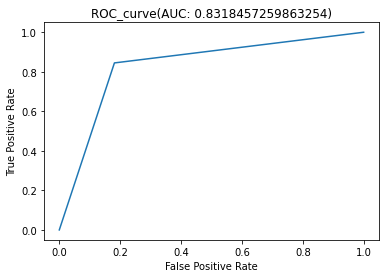

In [44]:
from sklearn.metrics import auc 
  
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test, pos_label=1) 
print('fpr: ' + str(fpr))
print('tpr: ' + str(tpr))
print('thresholds: ' + str(thresholds))
 
  
AUC = auc(fpr, tpr) 
print('AUC: ' + str(AUC))
 
print('\n\n')
plt.plot(fpr, tpr)  
plt.title('ROC_curve' + '(AUC: ' + str(AUC) + ')' )  
plt.ylabel('True Positive Rate')  
plt.xlabel('False Positive Rate')  
plt.show()

Сохранение в файл и проверка

In [45]:
joblib.dump(grid_search, "naive_bayes_model.pkl")
clf_naive_bayes = joblib.load("naive_bayes_model.pkl")
y_pred = clf_naive_bayes.predict(X_test)
accuracy_score(y_test, y_pred)

0.8302279026793964